In [212]:
import numpy as np
import astropy.io.fits as fits
from numpy import sqrt, pi, histogram, linspace, cumsum
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

In [213]:
SUN_ABSOLUTE_MAGNITUDE = 4.83
LOG_MASS_LUMINOSITY_RATIO_BINS = linspace(-1, 1, 100)
Z_MAX = 0.4

In [214]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 14,           # Font size for text
    'axes.titlesize': 16,      # Font size for axes titles
    'axes.labelsize': 14,      # Font size for x and y labels
    'xtick.labelsize': 14,     # Font size for x tick labels
    'ytick.labelsize': 14,     # Font size for y tick labels
    'legend.fontsize': 14,     # Font size for legend text
    'figure.figsize': (20, 12), # Default figure size
})

In [246]:
def get_distance_from_mass(mass_in_msol: float, log_cutoff_mass_to_light_ratio: float) -> float:
    # uses magnitude limit in r_band of 19.65 as mentioned in driver
    return 10**(19.65 / 5 + 1 + 0.5 * (np.log10(mass_in_msol) - log_cutoff_mass_to_light_ratio) - SUN_ABSOLUTE_MAGNITUDE / 5) / 10**6

def get_mass_luminosity_cutoff(galaxy_df: pd.DataFrame) -> float:
    '''
    calculate the M/L cutoff value for a survey of galaxies. the dataframe needs to have the following columns:
    z
    mstar
    flux_rt
    '''
    # get the mass luminosity histogram of our survey
    log_mass_luminosity_ratio_histogram = get_mass_luminosity_histogram(galaxy_df)[0]
        
    # normalize the histogram so it becomes a histogram of percentages
    histogram_of_percentages = log_mass_luminosity_ratio_histogram / len(galaxy_df) * 100
    # get the cumsum of the histogram
    cumsum_of_histogram = cumsum(histogram_of_percentages)
    # the ID of the bin is now that where the cumsum becomes larger than 95(%)
    bin_id = len(cumsum_of_histogram[cumsum_of_histogram < 80])
    # now we can find the center of the bin with ID bin_id which gives us our mass-luminosity-ratio cutoff
    return LOG_MASS_LUMINOSITY_RATIO_BINS[bin_id]


def get_mass_luminosity_histogram(galaxy_df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # get the luminosity distance from z
    #distances = cosmo.comoving_distance(galaxy_df['z']).value
    distances = galaxy_df['comoving_distance']
    # get the luminosity from flux and distance        
    luminosities = [get_luminosity_from_flux_and_distance(flux, distance) for (flux, distance) in zip(galaxy_df['flux_rt'], distances)]
    # calculate the ratios
    log_mass_luminosity_ratios = np.log10(galaxy_df['mstar'] / luminosities)
    # create the ratio-histogram
    return histogram(log_mass_luminosity_ratios, LOG_MASS_LUMINOSITY_RATIO_BINS)


def get_luminosity_from_flux_and_distance(flux: float, distance: float) -> float:
    # takes flux in Jansky and distance in Mpc
    # converts the units
    # returns luminosity in solar luminosities
    flux_in_jansky = flux * u.Jy
    distance_in_mpc = distance * u.Mpc
    effective_frequency = 4.87 * 10**14 / u.s
    
    luminosity = 4 * pi * distance_in_mpc**2 * flux_in_jansky * effective_frequency
    solar_luminosity = 1 * u.solLum    
    return luminosity.decompose() / solar_luminosity.decompose()
    

In [247]:
# small survey (this is the main one)
galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data
# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        # (galaxies_raw['SC'] > 7) &
        (galaxies_raw['Z'] <= Z_MAX) &
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < 1.304) &
        (galaxies_raw['RAcen'] > 129.0) &
        (galaxies_raw['RAcen'] < 141.0) &
        (galaxies_raw['Deccen'] > -2.0) &
        (galaxies_raw['Deccen'] < 3.0)  &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)
galaxy_catalog = galaxies_raw[galaxy_mask]
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
        'comoving_distance': galaxy_catalog['comovingdist'].byteswap().newbyteorder(),
        'i_band_log_mass_to_light_ration': galaxy_catalog['logmoverl_i'].byteswap().newbyteorder(),
})
print(len(galaxy_df))

45520


In [248]:
masses = 10**np.linspace(5,12.25,1000)

cutoff = get_mass_luminosity_cutoff(galaxy_df)
distance_cutoff = max(galaxy_df['comoving_distance'])
richards_curve = []
for mass in masses:
    distance = get_distance_from_mass(mass, cutoff)
    if distance < distance_cutoff:
        richards_curve.append(distance)
    else:
        richards_curve.append(distance_cutoff)

In [249]:
print(cutoff)

0.6767676767676769


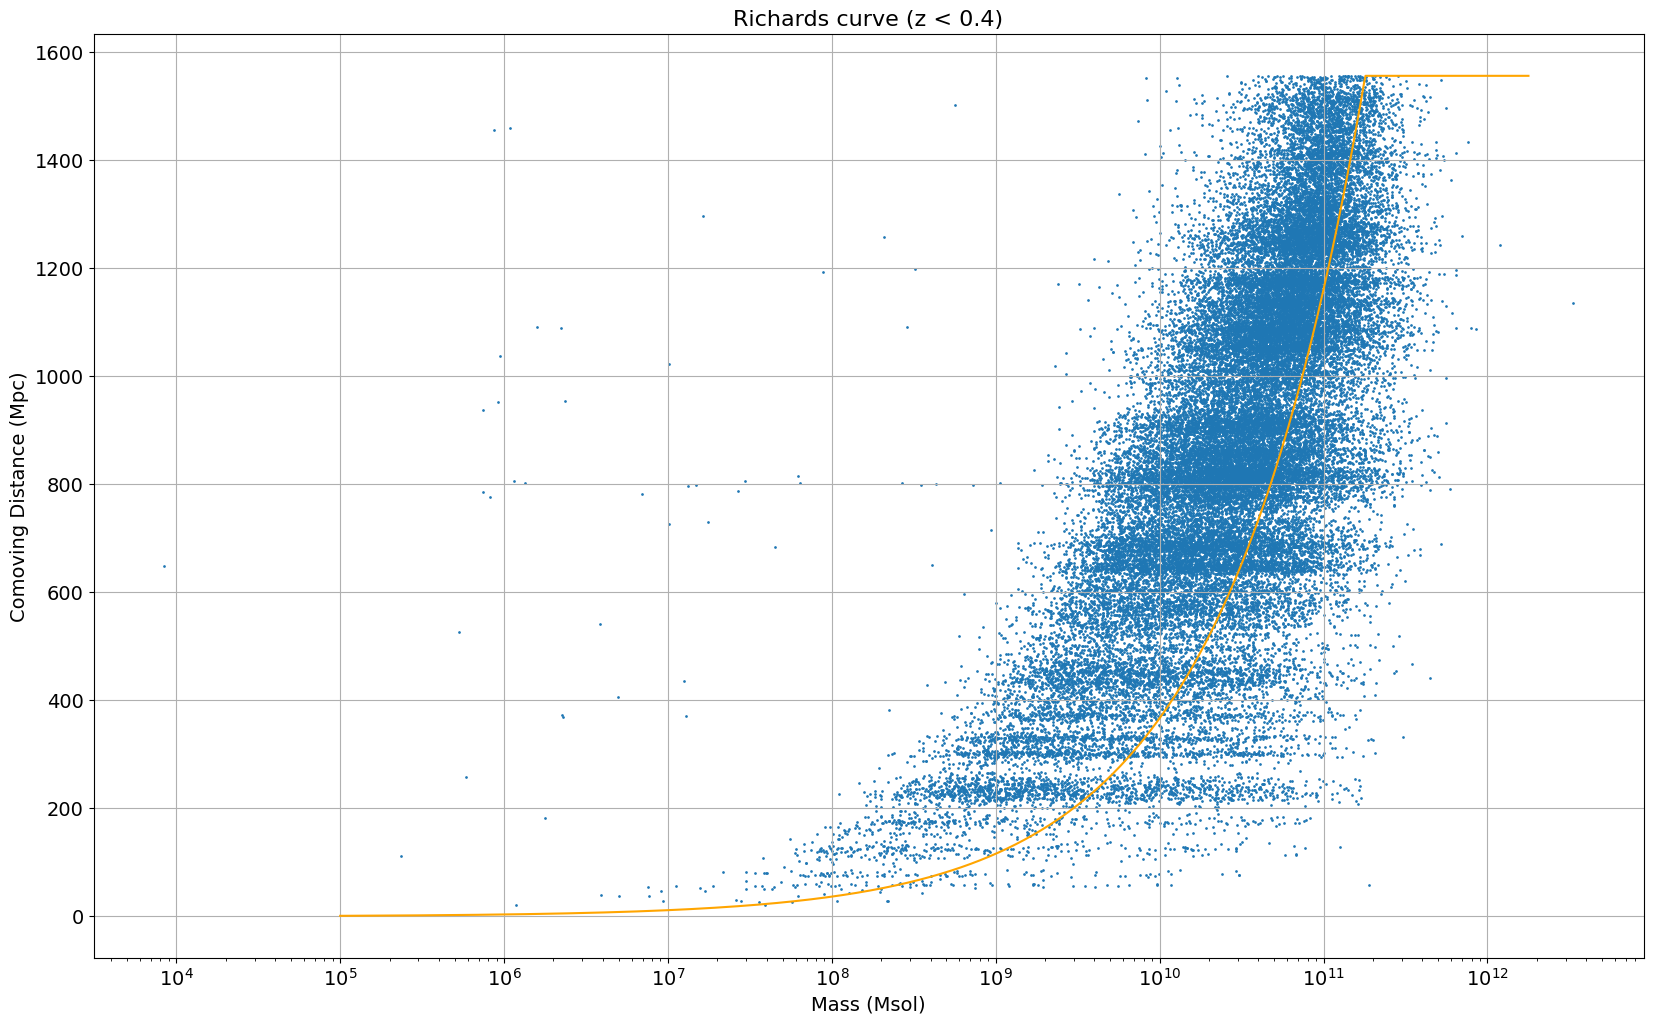

<Figure size 2000x1200 with 0 Axes>

In [243]:
plt.xscale("log")
plt.yscale("linear")
plt.scatter(galaxy_df['mstar'], galaxy_df['comoving_distance'], s=0.9, label='Data')
plt.plot(masses, richards_curve, color='orange')
plt.title(f'Richards curve (z < {Z_MAX})')
plt.xlabel('Mass (Msol)')
plt.ylabel('Comoving Distance (Mpc)')
plt.grid()
plt.show()
plt.savefig('../erosita_DR1/plots/driverfig10/richards_curve.png')

In [244]:
mass_luminosity_ratio_histogram, bins = get_mass_luminosity_histogram(galaxy_df)
mass_luminosity_ratio_histogram_low_mass = get_mass_luminosity_histogram(galaxy_df[galaxy_df['mstar'] < 10**10])
cutoff = get_mass_luminosity_cutoff(galaxy_df)
bin_width = bins[1] - bins[0]

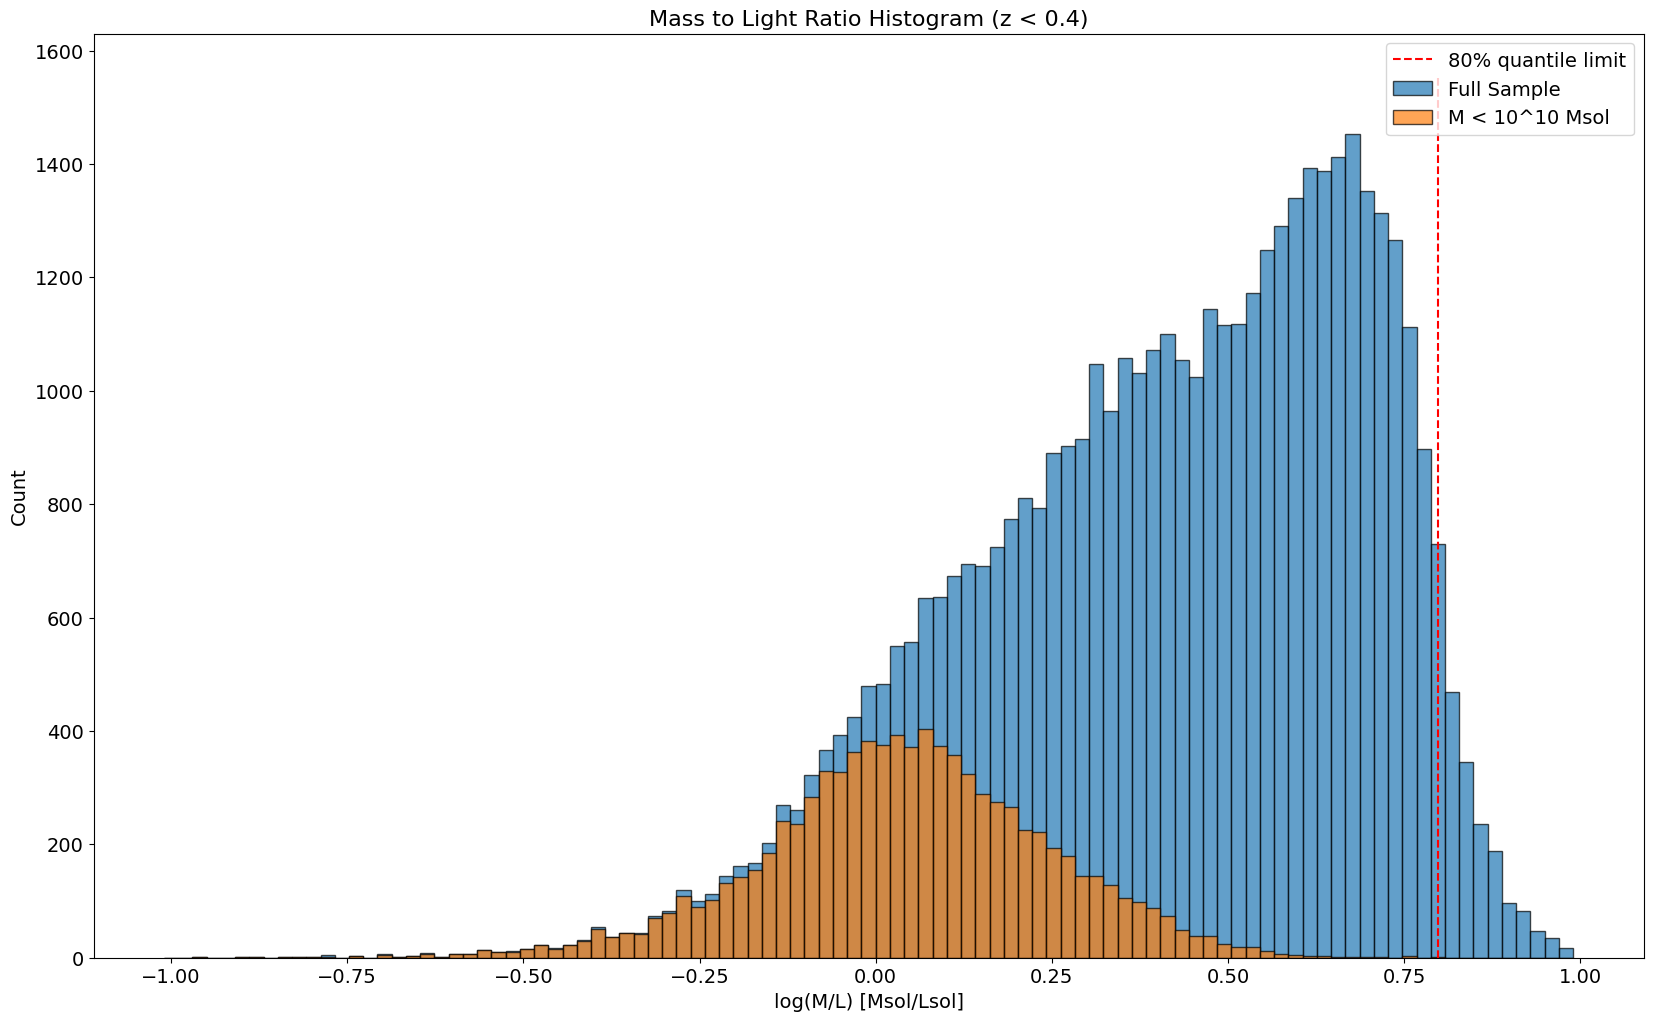

<Figure size 2000x1200 with 0 Axes>

In [245]:
plt.bar(bins[:-1], mass_luminosity_ratio_histogram, width=bin_width, edgecolor='black', alpha=0.7, label='Full Sample')
plt.bar(bins[:-1], mass_luminosity_ratio_histogram_low_mass[0], width=bin_width, edgecolor='black', alpha=0.7, label='M < 10^10 Msol')

plt.vlines(cutoff, ymin=0, ymax=(max(mass_luminosity_ratio_histogram))+100, linestyles='--', colors='red', label='80% quantile limit')
plt.title(f'Mass to Light Ratio Histogram (z < {Z_MAX})')
plt.xlabel('log(M/L) [Msol/Lsol]')
plt.ylabel('Count')
plt.legend()
plt.show()
plt.savefig('../erosita_DR1/plots/driverfig10/histogram.png')